In [404]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import time
# from sklearn.externals import joblib
import joblib
import pickle
import pylab as plt
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [38]:
data = pd.read_csv('./data.csv', encoding='GBK')

In [39]:
data.shape

(28901, 25)

In [40]:
data.head(3)

,id,site_id,asin,data_date,product_title,ordered_revenue,ordered_revenue_of_total,ordered_revenue_last_year,ordered_units,ordered_units_of_total,...,glance_views,change_in_glance_view_prior_period,change_in_gv_last_year,conversion_rate,rep_oos,rep_oos_of_total,rep_oos_prior_period,lbb_price,create_time,update_time
0,1,eb766123-9f24-436e-9117-49c739816794,B07GJBBGHG,2021/1/2,COSORI 5.8QT Electric Hot Air Fryers Oven Oill...,153827.18,0.13,1.26,1284,0.06,...,40220.0,0.00,1.19,0.03,0.02,0.14,0.15,0.0,2021/1/4 6:48,2021/1/4 6:48
1,5,eb766123-9f24-436e-9117-49c739816794,B07VLKMMJ5,2021/1/2,COSORI Smart WiFi Air Fryer 5.8QT(100 Recipes)...,44065.14,0.04,0.45,367,0.02,...,11543.0,-0.01,1.45,0.03,0.01,0.02,1.26,0.0,2021/1/4 6:48,2021/1/4 6:48
2,9,eb766123-9f24-436e-9117-49c739816794,B07T2LCKNF,2021/1/2,COSORI Air Fryer Max XL(100 Recipes) 5.8 QT El...,28797.60,0.02,4.14,241,0.01,...,5897.0,0.10,3.25,0.04,0.00,0.00,NaN,0.0,2021/1/4 6:48,2021/1/4 6:48


In [42]:
data.data_date = pd.to_datetime(data.data_date)

In [43]:
group = data.groupby([ 'asin', 'data_date']).agg({'ordered_units':sum})
group = group.reset_index()

In [44]:
group.head()

,asin,data_date,ordered_units
0,B071D7BTTW,2019-12-02,23
1,B071D7BTTW,2019-12-03,3
2,B071D7BTTW,2019-12-04,3
3,B071D7BTTW,2019-12-05,4
4,B071D7BTTW,2019-12-06,8


In [115]:
a

,asin,data_date,ordered_units
615,B074NYJL9J,2019-12-02,482
616,B074NYJL9J,2019-12-03,102
617,B074NYJL9J,2019-12-04,151
618,B074NYJL9J,2019-12-05,167
619,B074NYJL9J,2019-12-06,188
...,...,...,...
1236,B074NYJL9J,2021-08-18,24
1237,B074NYJL9J,2021-08-19,12
1238,B074NYJL9J,2021-08-20,6
1239,B074NYJL9J,2021-08-21,10


In [63]:
a = group.groupby('asin').get_group('B074NYJL9J')
plt.plot(a['data_date'], a['ordered_units'])

In [9]:
group.data_date = pd.to_datetime(group.data_date)

In [10]:
group['month'] = group.data_date.dt.month
group['year'] = group.data_date.dt.year
group['day'] = group.data_date.dt.day

In [11]:
group.head().append(group.tail())

,asin,data_date,ordered_units,month,year,day
0,B071D7BTTW,2019-12-10,5,12,2019,10
1,B071D7BTTW,2019-12-11,0,12,2019,11
2,B071D7BTTW,2019-12-12,1,12,2019,12
3,B071D7BTTW,2019-12-13,0,12,2019,13
4,B071D7BTTW,2019-12-14,0,12,2019,14
28896,B09BB74CLW,2021-08-18,2,8,2021,18
28897,B09BB74CLW,2021-08-19,1,8,2021,19
28898,B09BB74CLW,2021-08-20,2,8,2021,20
28899,B09BB74CLW,2021-08-21,0,8,2021,21
28900,B09BB74CLW,2021-08-22,0,8,2021,22


In [13]:
group1 = group.drop('data_date', axis=1)

In [15]:
group1

,asin,ordered_units,month,year,day
0,B071D7BTTW,5,12,2019,10
1,B071D7BTTW,0,12,2019,11
2,B071D7BTTW,1,12,2019,12
3,B071D7BTTW,0,12,2019,13
4,B071D7BTTW,0,12,2019,14
...,...,...,...,...,...
28896,B09BB74CLW,2,8,2021,18
28897,B09BB74CLW,1,8,2021,19
28898,B09BB74CLW,2,8,2021,20
28899,B09BB74CLW,0,8,2021,21


In [14]:
encoder = OneHotEncoder(sparse=False)

In [20]:
group1

,asin,ordered_units,month,year,day
0,B071D7BTTW,5,12,2019,10
1,B071D7BTTW,0,12,2019,11
2,B071D7BTTW,1,12,2019,12
3,B071D7BTTW,0,12,2019,13
4,B071D7BTTW,0,12,2019,14
...,...,...,...,...,...
28896,B09BB74CLW,2,8,2021,18
28897,B09BB74CLW,1,8,2021,19
28898,B09BB74CLW,2,8,2021,20
28899,B09BB74CLW,0,8,2021,21


In [348]:
data = encoder.fit_transform(group1[['asin', 'month', 'year', 'day']])

In [349]:
data.shape

(28901, 109)

In [23]:
# x = data.drop('ordered_units', axis=1)
y = group['ordered_units']

In [24]:
x_train, x_valid, y_train, y_valid = train_test_split(data, y, test_size=0.2)

In [336]:
y_pred = xgr.predict(x_valid)

In [337]:
np.sqrt(mean_squared_error(y_valid, y_pred))

230.0199377922727

## 保存读取

In [45]:
joblib.dump(encoder, 'onehot.pkl')

['onehot.pkl']

In [238]:
encoder = joblib.load('onehot.pkl')

In [182]:
def predict(asin, encoder, start_time='2019-12-01', end_time='2021-8-24'):
    date_range = pd.date_range(start_time, end_time)
    c = pd.DataFrame({'date':date_range, 'asin': asin})
    c['month'] = c.date.dt.month
    c['year'] = c.date.dt.year
    c['day'] = c.date.dt.day
    c1 = c.drop('date', axis=1)
    x1 = e.transform(c1)
    y_pred = xgr.predict(x1)
    plt.plot(c['date'], y_pred, c='r')
    
    return y_pred

只能预测2021年内的数据

In [287]:
group.asin.unique()

array(['B071D7BTTW', 'B074NYJL9J', 'B076DZJSHL', 'B07FKN76ZS',
       'B07FP5PHG4', 'B07G9J4745', 'B07GJBBGHG', 'B07GJJ71XS',
       'B07LCW5S2H', 'B07MPC7C8G', 'B07NL1L4SL', 'B07PY5M579',
       'B07QDSHKV1', 'B07QDSNFS2', 'B07QHSZGXC', 'B07RWPQ9TM',
       'B07SKJV5KV', 'B07T1BCN91', 'B07T1CH2HH', 'B07T2LCKNF',
       'B07T2LGN8P', 'B07T4HX1LH', 'B07VLKMMJ5', 'B07VNPQ2NF',
       'B07VXQMR7G', 'B07VXVFKWV', 'B07W67NQMN', 'B07W8MGPJX',
       'B07WBSVH33', 'B07WYYRZK7', 'B07WZF33ZT', 'B07X2JP8HP',
       'B07X3JDVHK', 'B07XS37FPV', 'B07YBB5SKG', 'B07YL6QWLK',
       'B081LQMXKP', 'B081NLFM91', 'B0821DTMGT', 'B083JBM9CZ',
       'B085W3GN5J', 'B0895G46CG', 'B0895GS9NW', 'B089SGRVBJ',
       'B089ZT66H9', 'B08BFMV68M', 'B08BFS92RP', 'B08FX4BR51',
       'B08GBY2BK8', 'B08K8T3W2V', 'B08L39951F', 'B08L3L4ZZX',
       'B08LYY2HHJ', 'B08NSVZY1K', 'B08PC1WNNX', 'B08PP48979',
       'B08QM92YBH', 'B08THPNHJK', 'B08YDQSG55', 'B095346VH6',
       'B097HG13D1', 'B0999CJBD9', 'B09BB74CLW'], dtype

In [429]:
asin = 'B074NYJL9J'

In [430]:
def get_y_true(asin, start, end):
    """
    指定型号的产品销量和日期
    """
    a = group[(group['asin'] == asin)
      & (group['data_date'] >= start) 
      & (group['data_date'] <= end)
     ]
    y_train = a['ordered_units']
    
    a['month'] = a.data_date.dt.month
    a['year'] = a.data_date.dt.year
    a['day'] = a.data_date.dt.day
    x_train = a.drop(['data_date', 'ordered_units'], axis=1)
    
    return x_train, y_train

2019-12-02 ~ 2021-7-22的数据为训练数据，2021-7-22 ~ 2021-8-22的数据为验证数据

In [431]:
x_train, y_train = get_y_true(asin, '2019-12-02', '2021-07-22')

In [432]:
x_valid, y_valid = get_y_true(asin, '2021-07-23', '2021-08-22')

In [433]:
x_valid

,asin,month,year,day
1210,B074NYJL9J,7,2021,23
1211,B074NYJL9J,7,2021,24
1212,B074NYJL9J,7,2021,25
1213,B074NYJL9J,7,2021,26
1214,B074NYJL9J,7,2021,27
1215,B074NYJL9J,7,2021,28
1216,B074NYJL9J,7,2021,29
1217,B074NYJL9J,7,2021,30
1218,B074NYJL9J,7,2021,31
1219,B074NYJL9J,8,2021,1


In [435]:
x_train = encoder.transform(x_train)
x_valid = encoder.transform(x_valid)

In [436]:
xgbr = XGBRegressor()

In [437]:
xgbr.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [439]:
x_valid.shape

(31, 109)

In [440]:
y_valid.shape

(31,)

In [441]:
y_pred = xgbr.predict(x_valid)

In [442]:
mean_squared_error(y_valid, y_pred)

112.30428810651584

In [367]:
y_true = o.ordered_units

In [368]:
m = pd.DataFrame({'date': o.data_date, 'asin': asin})
m['month'] = m.date.dt.month
m['year'] = m.date.dt.year
m['day'] = m.date.dt.day
m1 = m.drop('date', axis=1)
m1

,asin,month,year,day
0,B071D7BTTW,12,2019,2
1,B071D7BTTW,12,2019,3
2,B071D7BTTW,12,2019,4
3,B071D7BTTW,12,2019,5
4,B071D7BTTW,12,2019,6
...,...,...,...,...
610,B071D7BTTW,8,2021,17
611,B071D7BTTW,8,2021,18
612,B071D7BTTW,8,2021,19
613,B071D7BTTW,8,2021,20


In [369]:
xx = encoder.transform(m1)

In [ ]:
xgr = XGBRegressor(n_estimators=1400)
xgr.fit(data, y)

In [370]:
y_pred = xgr.predict(xx)
mean_squared_error(y_true, y_pred)

36.93794208200629

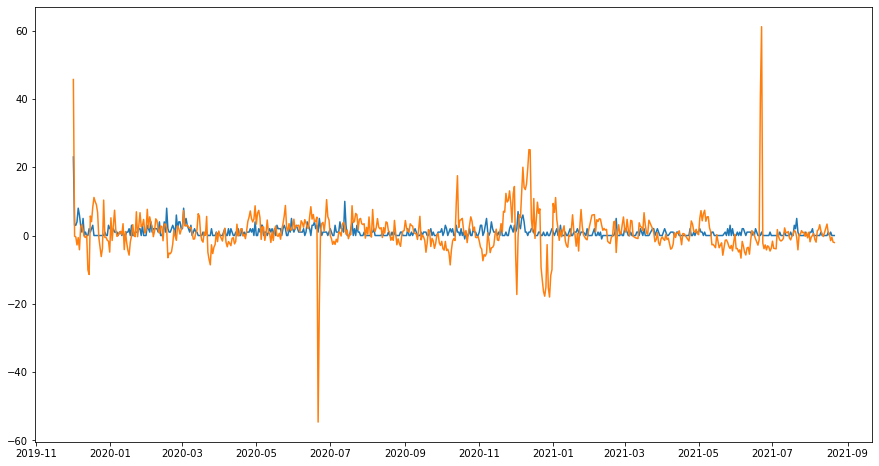

In [371]:
plt.figure(figsize=(15, 8))
plt.plot(o.data_date, y_true)
plt.plot(o.data_date, y_pred)

某些型号某些天可能没有数据

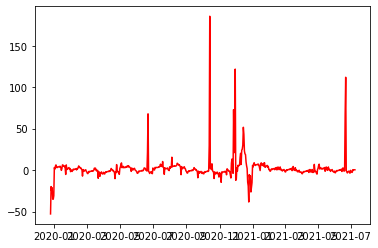

In [263]:
y_pred = predict(asin, encoder, start_time, end_time)

In [134]:
def true_plot(asin):
    a = group.groupby('asin').get_group(asin)
    plt.xticks(rotation=90)
    plt.plot(a['data_date'], a['ordered_units'], c='b')

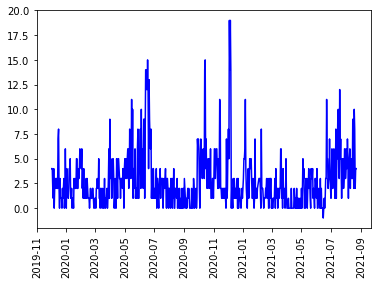

In [137]:
true_plot('B076DZJSHL')

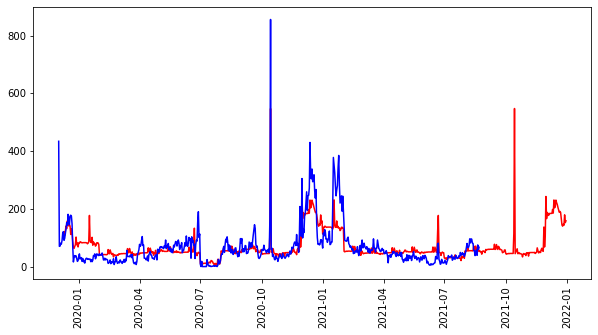

In [183]:
index = 9
plt.figure(figsize=(10,5))
predict(group.asin.unique()[index], encoder, '2019-12-09', '2021-12-30')
true_plot(group.asin.unique()[index])

In [103]:
date_range = pd.date_range(start_time, end_time)

In [104]:
c = pd.DataFrame({'date':date_range, 'asin': asin})

In [105]:
# c['week'] = c.date.dt.week
c['month'] = c.date.dt.month
c['year'] = c.date.dt.year
c['day'] = c.date.dt.day

In [106]:
c.head()

,date,asin,month,year,day
0,2019-12-01,B074NYJL9J,12,2019,1
1,2019-12-02,B074NYJL9J,12,2019,2
2,2019-12-03,B074NYJL9J,12,2019,3
3,2019-12-04,B074NYJL9J,12,2019,4
4,2019-12-05,B074NYJL9J,12,2019,5
